Viscous Inviscid Interaction with Thwaites Method

Group 1 : \\
Bryan 13619042

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Airfoil & Panel Generator








**FUNCTION**  : get_Airfoil, create_Panel, Calculate_Beta

**INPUT**     : Airfoil Data coordinates

**OUTPUT**    : XB, YB, XC, YC, n, phi, S, beta

**STEP**:
1. Get airfoil from uploaded data (XB,YB)
2. Create the panel on the airfoil surface (XC,YC,S)
3. Calculate panels angle (phi,beta)

In [ ]:
#Read Airfoil Data
def readAirfoilData(airfoilPath):
    Xb = []
    Yb = []
   
    f = open(airfoilPath, "r")
    for data in f:
        splittedData = data.rstrip().split(";")
        Xb.append(float(splittedData[0]))
        Yb.append(float(splittedData[1]))

    Xb = np.array(Xb[::-1], dtype=float)
    Yb = np.array(Yb[::-1], dtype=float)
    n = len(Xb)-1

    return (Xb, Yb, n)

def create_Panel(XB, YB, n):
        
    # Coordinates of Panel Midpoint and Length of each Panel
    XC = np.zeros((n,1), dtype=float)
    YC = np.zeros((n,1), dtype=float)
    S = np.zeros((n,1), dtype=float)
    
    # Angle of each Panel
    phi = np.zeros((n,1), dtype=float)
    
    for i in range(n):
        
        XC[i] = (XB[i] + XB[i+1])/2
        YC[i] = (YB[i] + YB[i+1])/2
        S[i] = math.sqrt((XB[i] - XB[i+1])**2 + (YB[i] - YB[i+1])**2)
        
        phi[i] = math.atan2((YB[i+1] - YB[i]), (XB[i+1] - XB[i]))
            
    return XC, YC, phi, S

def Calculate_Beta(phi, AoA, n):
    beta = np.zeros((n,1), dtype=float)
    
    for i in range(n):
        beta[i] = phi[i] + np.pi/2 - AoA*np.pi/180
        
        if (phi[i] < 0):                              
            phi[i] = phi[i] + 2*np.pi
        if (beta[i] < 0):                              
            beta[i] = beta[i] + 2*np.pi
            
    return phi, beta

 
# Vortex Panel Method (Inviscid Program)


**VPM Coefficient Computation**

Credit: Edwin et al.

**FUNCTION**: Compute_Matrix_A

**INPUT**: XC, YC, XB, YB, phi, S, n

**OUTPUT**: A, I, J, K, L

**STEP**:

1. Initialize Coeff IJKL
2. Compute Coeff A, B, Cn_S, Dn_S, Ct_S, Dt_S, E, Cn_V, Dn_V, Ct_V, Dt_V
3. Compute I,J,K,L (term1,term2)
4. Zero out problematic value
5. Output I,J,K,L

In [ ]:
def Compute_Matrix_A(XC, YC, XB, YB, phi, S, n):

    I = np.zeros((n,n))                                                   
    J = np.zeros((n,n)) 
    K = np.zeros((n,n))                                                   
    L = np.zeros((n,n)) 
    
    # Compute coefficients A, B, C, D, E
    for i in range(n):                                                         
        for j in range(n):                                                     
            if (j != i):
                
                A  = -(XC[i]-XB[j])*np.cos(phi[j])-(YC[i]-YB[j])*np.sin(phi[j])     
                B  = (XC[i]-XB[j])**2 + (YC[i]-YB[j])**2                            
                Cn_S = np.sin(phi[i]-phi[j])                                          
                Dn_S = -(XC[i]-XB[j])*np.sin(phi[i])+(YC[i]-YB[j])*np.cos(phi[i])     
                Ct_S = -np.cos(phi[i]-phi[j])                                         
                Dt_S = (XC[i]-XB[j])*np.cos(phi[i])+(YC[i]-YB[j])*np.sin(phi[i])      
                E  = np.sqrt(B-A**2)

                

                Cn_V = Ct_S                                         
                Dn_V = Dt_S      
                Ct_V = Cn_S                                        
                Dt_V = -Dn_S     

                if (E == 0 or np.iscomplex(E) or np.isnan(E) or np.isinf(E)):       
                    I[i,j] = 0                                                      
                    J[i,j] = 0
                    K[i,j] = 0                                                      
                    L[i,j] = 0
                else:
                    # Compute I (Source normal component)
                    term1  = 0.5*Cn_S*np.log((S[j]**2 + 2*A*S[j] + B)/B)              
                    term2  = ((Dn_S-A*Cn_S)/E)*(math.atan2((S[j]+A),E)-math.atan2(A,E)) 
                    I[i,j] = term1 + term2                                          
                    
                    # Compute J (Source tangential component)
                    term1  = 0.5*Ct_S*np.log((S[j]**2 + 2*A*S[j] + B)/B)              
                    term2  = ((Dt_S-A*Ct_S)/E)*(math.atan2((S[j]+A),E)-math.atan2(A,E)) 
                    J[i,j] = term1 + term2       
                    
                    # Compute K (Vortex normal component)
                    term1  = 0.5*Cn_V*np.log((S[j]**2 + 2*A*S[j] + B)/B)              
                    term2  = ((Dn_V-A*Cn_V)/E)*(math.atan2((S[j]+A),E)-math.atan2(A,E)) 
                    K[i,j] = term1 + term2                                          
                    
                    # Compute L (Vortex tangential component)
                    term1  = 0.5*Ct_V*np.log((S[j]**2 + 2*A*S[j] + B)/B)              
                    term2  = ((Dt_V-A*Ct_V)/E)*(math.atan2((S[j]+A),E)-math.atan2(A,E)) 
                    L[i,j] = term1 + term2 
            
            # Zero out any problematic values
            if (np.iscomplex(I[i,j]) or np.isnan(I[i,j]) or np.isinf(I[i,j])):      
                I[i,j] = 0                                                          
            if (np.iscomplex(J[i,j]) or np.isnan(J[i,j]) or np.isinf(J[i,j])):      
                J[i,j] = 0  
            if (np.iscomplex(K[i,j]) or np.isnan(K[i,j]) or np.isinf(K[i,j])):      
                K[i,j] = 0                                                          
            if (np.iscomplex(L[i,j]) or np.isnan(L[i,j]) or np.isinf(L[i,j])):      
                L[i,j] = 0 
    
    # Create Matrix A
    A = np.zeros((n+1,n+1), dtype=float)
    
    # Elements of Matrix A
    for i in range(n):
        for j in range(n):
            if (i == j):
                A[i,j] = math.pi
            else:
                A[i,j] = I[i,j]
                
    for i in range(n):      
        # Right Column of A
        A[i,-1] = -sum(K[i,:])
        
        # Bottom Row of A
        A[-1,i] = J[0,i] + J[-1,i]
    
    A[-1,-1] = -(sum(L[0,:]) + sum(L[1,:])) + 2*math.pi
    
    return I, J, K, L, A

**VPM Calculation**

**FUNCTION**: VortexPanelMethod

**INPUT** : AoA, Vinf, Un, S, XC, beta, I, J, K, L

**OUTPUT** : Vn, Vt, Cp, CL, CM, lmbda, gamma, A, B, x

**STEP**:

1. Create Matrix A and Vector B 
2. Elements of Matrix A and Vector B
3. Solve Source and Vortex Strength
4. Define Velocity and Pressure Coefficient
5. Calculate Velocity, Pressure Coeff, Lift and Moment Coeff

In [ ]:
def VortexPanelMethod(AoA, Vinf, Un, S, XC, phi, beta, I, J, K, L, A, n):
    
    AoAR = AoA*np.pi/180
    
    # Create Vector B 
    B = np.zeros((n+1,1), dtype=float)
      
    #Elements of Vector B
    for i in range(n):
        
        B[i,0] = 2*math.pi*(Un[i] - Vinf*np.cos(beta[i]))
        
    B[-1,0] = -2*math.pi*Vinf*(np.sin(beta[0]) + np.sin(beta[-1]))
    
    # Solve Source and Vortex Strength
    x = np.linalg.solve(A,B)
    
    lmbda = x[0:-1]
    gamma = x[-1]
    
    # Velocity and Pressure Coefficient
    Vt = np.zeros((n,1), dtype=float)
    Vn = np.zeros((n,1), dtype=float)
    Cp = np.zeros((n+1), dtype=float)
    
    # Calculate Velocity
    for i in range(n):
        Vn[i] = Vinf*np.cos(beta[i]) + lmbda[i]/2
        Vt[i] = Vinf*np.sin(beta[i]) + gamma/2
        
        for j in range(n):
            if (j != i):
                Vn[i] += (lmbda[j]*I[i,j]-gamma*K[i,j])/(2*math.pi)
                Vt[i] += (lmbda[j]*J[i,j]-gamma*L[i,j])/(2*math.pi)
                
    # Calculate Pressure Coefficient
    Cp = 1 - (Vn**2+Vt**2)/Vinf**2
        
    return Vn, Vt, Cp, lmbda, gamma, B

# Thwaites Correlation (Viscous Program)

**Create Stagnation Point**

**FUNCTION**: stagnation

**INPUT**: n, Vt

**OUTPUT**: i, n_upper, n_lower



In [ ]:
def stagnation(n, Vt):
    for i in range(1,n):
        if (Vt[i]/Vt[0] >= 0):
            continue
        else:
            break
            
    n_upper = n - i
    n_lower = i
    
    return i, n_upper, n_lower

**Upper - Lower Airfoil**

**FUNCTION**: divide_Upper_Lower

**INPUT**: K, i_s

**OUTPUT**: K_upper, K_lower


In [ ]:
def divide_Upper_Lower(K, i_s):
    
    n = len(K)
    
    K_lower = np.zeros(i_s)
    K_upper = np.zeros(n-i_s)
    
    for i in range(i_s):
        K_lower[i] = K[i_s-1-i]
        
    for i in range(i_s, n):
        K_upper[i-i_s] = K[i]
    
    return K_upper, K_lower

**Thwaites Upper Airfoil Calculation**

**FUNCTION**: Calculate_Thwaites_Upper 

**INPUT**: n, rho, mu, XB, XC, S, Vt

**OUTPUT**: theta, theta_2, lam, Tau_w, Delta_Star, Un

**STEP**: 

1. Calculate Theta^2, Lambda, Theta
2. Calculate S and H
3. Calculate Tau_w and Delta_Star

In [ ]:
def Calculate_Thwaites_Upper(n, i_s, rho, mu, XB, YB, XC, YC, S, AoA, Vt):
    
    nu = mu/rho
    AoAR = AoA*np.pi/180
    
    XB_new = XB.copy()
    YB_new = YB.copy()
    XC_new = XC.copy()
    YC_new = YC.copy()
    
    for i in range(n):
        XB_new[i] = XB[i]*np.cos(-AoAR) - YB[i]*np.sin(-AoAR)
        YB_new[i] = YB[i]*np.cos(-AoAR) + XB[i]*np.sin(-AoAR)
    
    
    # Calculate Theta^2
    theta   = np.zeros(n)
    theta_2 = np.zeros(n)

    for i in range(n):
        integral = 0
        for j in range(i+1):
            integral += (Vt[j]**5)*abs(XB_new[j+1]-XB_new[j])
        theta_2[i] = 0.45*nu*integral/(Vt[i]**6)
        
       
    # Calculate Lambda
    lam = np.zeros(n)
    
    sep = []
    
    for i in range(n):
        if (i != n-1):
            if XC_new[i+1] == XC_new[i]:
                lam[i] = lam[i-1]
            else:
                lam[i] = float(theta_2[i]/nu*(Vt[i+1]-Vt[i])/(XB_new[i+1]-XB_new[i]))
        else:
            lam[i] = lam[i-1]
                
        if lam[i] < -0.09:
            lam[i] = -0.09
            if i_s + i >= 51: 
                sep.append(i)

    n_sep = sep[0]   
    
    # Calculate Theta
    for i in range(n):
        theta[i] = math.sqrt(theta_2[i])
    
    # Calculate S and H
    
    S_lam = np.zeros(n)
    H = np.zeros(n)
    z = np.zeros(n)
    
    for i in range(n):
        S_lam[i] = math.pow(lam[i] + 0.09, 0.62)
        z[i] = 0.25 - lam[i]
        H[i] = 2 + 4.14*z[i] - 83.5*z[i]**2 + 854*z[i]**3 - 3337*z[i]**4 + 4576*z[i]**5
    
        if H[i] <= 0:
            H[i] = 0
        
    # Calculate Tau_w and Delta_Star
    
    Tau_w      = np.zeros(n)
    Delta_Star = np.zeros(n)
    Un         = np.zeros(n)
    
    for i in range(n-1):
        Tau_w[i]      = mu*Vt[i]/theta[i]*S_lam[i]
        Delta_Star[i] = theta[i]*H[i]
        Un[i]         = Delta_Star[i]*0.03
    
    Tau_w[-1]      = Tau_w[-2]
    Delta_Star[-1] = Delta_Star[-2]
    Un[-1]         = Un[-2]
        
    Cf = 2*Tau_w/(rho*Vt**2)
    
    return theta, lam, Delta_Star, Un, Cf, n_sep, H

**Thwaites Lower Airfoil Calculation**

**FUNCTION**: Calculate_Thwaites_Lower

**INPUT**: n, rho, mu, XB, XC, S, Vt

**OUTPUT**: theta, theta_2, lam, Tau_w, Delta_Star, Un

**STEP**: 

1. Take absolute value of tangential velocity

2. Just reverse the function of Calculate_Thwaites_Upper




In [ ]:
def Calculate_Thwaites_Lower(n, i_s, rho, mu, XB, YB, XC, YC, S, AoA, Vt):
        
    _Vt = abs(Vt)
    
    theta, lam, Delta_Star, Un, Cf, n_sep, H = Calculate_Thwaites_Upper(n, i_s, rho, mu, XB, YB, XC, YC, S, AoA, _Vt)
    #plt.plot(lam)

    theta      = theta[::-1]
    lam        = lam[::-1]
    Delta_Star = Delta_Star[::-1]
    Un         = Un[::-1]
    Cf         = Cf[::-1]
    H          = H[::-1]

    n_sep = n-1-n_sep
    return theta, lam, Delta_Star, Un, Cf, n_sep, H

**Thwaites Correlation**

**FUNCTION**: Thwaites

**INPUT**: n, rho, mu, XB, YB, XC, YC, S, beta, Vt

**OUTPUT**: theta, theta_2, lam, Tau_w, Delta_Star, Un, i_s

**STEP**: 

1. Stagnation on Airfoil Panel
2. Divide Upper-Lower Airfoil
3. Calculate Thwaites




In [ ]:
def Thwaites(n, rho, mu, XB, YB, XC, YC, S, beta, Vt):
    
    # Number of Upper and Lower Panel
    i_s, n_upper, n_lower = stagnation(n, Vt)
    
    # Divide Upper Lower Airfoil
    XC_upper  , XC_lower   = divide_Upper_Lower(XC, i_s)
    YC_upper  , YC_lower   = divide_Upper_Lower(YC, i_s)
    S_upper   , S_lower    = divide_Upper_Lower(S, i_s)
    Vt_upper  , Vt_lower   = divide_Upper_Lower(Vt, i_s)
    XB_upper  , XB_lower   = divide_Upper_Lower(XB, i_s)  
    XB_lower = np.append(XB_upper[0], XB_lower)
    YB_upper  , YB_lower   = divide_Upper_Lower(YB, i_s)  
    YB_lower = np.append(YB_upper[0], YB_lower)
  

    # Calculate Thwaites
    theta, lam, Delta_Star, Un, Cf, n_sep, H= Calculate_Thwaites_Upper(n_upper, i_s, rho, mu ,XB_upper, YB_upper, XC_upper, YC_upper, S_upper, AoA, Vt_upper)
    thetal, laml, Delta_Starl, Unl, Cfl, n_sepl, H1= Calculate_Thwaites_Lower(n_lower, i_s, rho, mu ,XB_lower, YB_lower, XC_lower, YC_lower, S_lower, AoA, Vt_lower)
    

    theta      = np.append(thetal, theta)
    lam        = np.append(laml, lam)
    Delta_Star = np.append(Delta_Starl, Delta_Star)
    Un         = np.append(Unl, Un)
    Cf         = np.append(Cfl,Cf)
    H          = np.append(H1, H)


    n_sep = i_s + n_sep
    
    #modifying the shape factor : 
    for i in range(1, n) : 
      if(H[i]<=0) :
        H[i] = H[i-1];
    


    # calculate the derivative of U_inf
    U_inf_u = np.zeros(n_upper)
    U_inf_l = np.zeros(n_lower)
    dU_inf_u = np.zeros(n_upper)     # first derivative of U_inf wrt local x
    dU_inf_l = np.zeros(n_lower)
    
    for i in range(1,n_upper):
        U_inf_u[i] = abs(Vt[i_s+i])
        
    for i in range(n_upper-1) : 
      if XC_upper[i+1] - XC_upper[i] != 0 : 
        dU_inf_u[i] = (U_inf_u[i+1]-U_inf_u[i])/(XC_upper[i+1]-XC_upper[i]) # forward difference
      else :
        dU_inf_u[i] = dU_inf_u[i-1]
    
    
    for i in range(1,n_lower) :
        U_inf_l[i] = abs(Vt[i_s-i])
        
    for i in range(n_lower-1) :
      if XC_lower[i+1] - XC_lower[i] != 0 : 
        dU_inf_l[i] = (U_inf_l[i+1]-U_inf_l[i])/(XC_lower[i+1]-XC_lower[i])
      else :
        dU_inf_l[i] = dU_inf_l[i-1]


    #obtaining u and dudx
    u = np.zeros(n)
    dudx = np.zeros(n)

    for i in range(n_lower):
        u[i] = U_inf_l[n_lower-1-i] 
        dudx[i] = dU_inf_l[n_lower-1-i] 
    for i in range(n_upper-1) :
        u[n_lower+i] = U_inf_u[i+1]
        dudx[n_lower+i] = dU_inf_u[i+1]
        
    
    
    return theta, lam, Delta_Star, Un, Cf, i_s, n_sep, n_sepl, n_upper, n_lower, H, u, dudx

In [ ]:
def Calculate_Cl_Cd(Cp, Cf, phi, beta, AoA, i_s, n):
    
    AoAR = AoA*np.pi/180
        
    CN1 = np.zeros((n,1), dtype = float)
    CA1 = np.zeros((n,1), dtype = float)
    CN2 = np.zeros((n,1), dtype = float)
    CA2 = np.zeros((n,1), dtype = float)
    
    CL = 0
    CD_V = 0
    CD_P = 0
    CD = 0
    
    for i in range(n):
        # Calculate Coefficients From Cp
        CN1[i] = -Cp[i]*S[i]*np.sin(beta[i] + AoAR)                          
        CA1[i] = -Cp[i]*S[i]*np.cos(beta[i] + AoAR)                     

        # Calculate Coefficients From Cf
        CA2[i] = abs(Cf[i]*S[i]*np.sin(beta[i] + AoAR))
        CN2[i] = CA2[i]/np.tan(beta[i]+AoAR)

        CL += (CN1[i]+CN2[i])*np.cos(AoAR) - (CA1[i]+CA2[i])*np.sin(AoAR)
        CD += (CN1[i]+CN2[i])*np.sin(AoAR) + (CA1[i]+CA2[i])*np.cos(AoAR)
        CD_V += (CN2[i])*np.sin(AoAR) + (CA2[i])*np.cos(AoAR)
        CD_P += (CN1[i])*np.sin(AoAR) + (CA1[i])*np.cos(AoAR)
    
    return CL, CD_V, CD_P, CD, CN1, CN2, CA1, CA2

**Transition**

Method : Michel or Cebeci-Smith transition

In [ ]:
def transition(U_inf, theta, nu, num_upper_panel, num_lower_panel, XC, YC, i_s) :
  #defining the parts of XC and theta : 
  xu  , xl   = divide_Upper_Lower(XC, i_s)
  yu  , yl   = divide_Upper_Lower(YC, i_s)
  theta_u, theta_l = divide_Upper_Lower(theta, i_s)
  
  
  # calculate the derivative of U_inf
  U_inf_u = np.zeros(num_upper_panel)
  U_inf_l = np.zeros(num_lower_panel)
  dU_inf_u = np.zeros(num_upper_panel)     # first derivative of U_inf wrt local x
  dU_inf_l = np.zeros(num_lower_panel)
  
  for i in range(1,num_upper_panel):
      U_inf_u[i] = abs(U_inf[i_s+i])
      
  for i in range(num_upper_panel-1) : 
      dU_inf_u[i] = (U_inf_u[i+1]-U_inf_u[i])/(xu[i+1]-xu[i]) # forward difference
  
  
  for i in range(1,num_lower_panel) :
      U_inf_l[i] = abs(U_inf[i_s-i])
      
  for i in range(num_lower_panel-1) :
      dU_inf_l[i] = (U_inf_l[i+1]-U_inf_l[i])/(xl[i+1]-xl[i])

  #Length calculation
  length_up = np.zeros(num_upper_panel)
  length_down = np.zeros(num_lower_panel)

  #Upper surface
  for i in range(0, num_upper_panel) :
    if i == 0 :
      length_up[i] = np.sqrt( (xu[i])**2 + (yu[i])**2 )
    else : 
      length_up[i] = np.sqrt( (xu[i] - xu[i-1])**2 + (yu[i] - yu[i-1])**2 )

  for i in range(0, num_lower_panel) :
    if i == 0 :
      length_down[i] = np.sqrt( (xl[i])**2 + (yl[i])**2 )
    else : 
      length_down[i] = np.sqrt( (xl[i] - xl[i-1])**2 + (yl[i] - yl[i-1])**2 )

      

  #Transition calculation 
  for i in range(1,num_upper_panel) :
    Rtheta = U_inf_u[i]*theta_u[i]/nu
    Rx = U_inf_u[i]*length_up[i]/nu
    Rtrans = 2.9*(Rx**0.4) #Michel (1952)
    #Rtrans = 1.174*(1+22400/(Rx))*(Rx**0.46)
    
    if Rtheta > Rtrans :
        i_out_u = i_s + i
        break
        
    
  for i in range(1,num_lower_panel):
    Rtheta = U_inf_l[i]*theta_l[i]/nu
    Rx = U_inf_l[i]*length_down[i]/nu
    Rtrans = 2.9*(Rx**0.4) #Michel (1952)
    #Rtrans = 1.174*(1+22400/(Rx))*(Rx**0.46)
    
    
    if Rtheta > Rtrans :
        i_out_l = i_s-i
        break
  
  return i_out_l, i_out_u

**Turbulent Boundary Layer**

**Method** : Head's Lag-Entrainment Method

In [ ]:
def f_CE_eq0(nu,u,theta,H):
    # Varaibales container (y), calculate CE_eq0
    y = np.zeros(3)
    
    if (H < 4):
        H1      = 3.15 + 1.72/(H-1) - 0.01*(H-1)**2        
    else:
        H1      = 1.75 - 5.22273*H/(H+5.818181)
    
    Rt = u*theta/nu
    
    Cf0 = 0.01013/(np.log10(Rt) - 1.02) - 0.00075
    if (Cf0 < 0):
        Cf0 = 1e-5
    
    H0 = 1/(1 - 6.55*np.sqrt(Cf0/2))
    
    Cf = Cf0*(0.9/(H/H0 - 0.4) - 0.5)
    
    tududx_eq0 = (1.25/H)*(Cf/2 - ((H-1)/(6.432*H))**2)
    
    CE_eq0 = H1*(Cf/2 - (H+1)*tududx_eq0)
    
    # write the variable values
    y[0] = theta
    y[1] = H
    y[2] = CE_eq0
    
    return y

def f_Ct(CE,Cf0):
    Ct = 0.024*CE + 1.2*CE**2 + 0.32*Cf0
    
    return Ct

#%% Function to compute Cf
def f_Cf(nu,u,theta,H):
    Rt = u*theta/nu
    
    Cf0 = 0.01013/(np.log10(Rt) - 1.02) - 0.00075
    if (Cf0 < 0):
        Cf0 = 1e-5
    H0 = 1/(1 - 6.55*np.sqrt(Cf0/2))
    
    Cf = Cf0*(0.9/(H/H0 - 0.4) - 0.5)
    
    #Cf = 0.246/((10**(0.678*H))*(Rt**0.268))
    return Cf
  
  #%% Three Main Equations + Closures
# Main variabels:
    # y[0] = theta  (BL Momentum thickness)
    # y[1] = H      (BL Shape factor)
    # y[2] = CE     (Entrainment Coefficient)
# Output:
    # f[0] = dtheta/dx  (Von Karman Integral Relation (VKIR))
    # f[1] = dH/dx      (Head's Entrainment Eq)
    # f[2] = dCE/dx     (Lag Equation (Non-Equilibrium))

def f_3Eqs(nu,u,dudx,y):
    f = np.zeros(3)
    
    theta = y[0]
    H = y[1]
    CE = y[2]
    
    # Closures:
    
    if (H<4):
        H1      = (3.15 + 1.72/(H-1) - 0.01*(H-1)**2)
        dHdH1   = - 0.15*((H-1)**2)/(1.72+0.02*(H-1)**3)
    else:
        H1      = (1.75 - 5.22273*H/(H+5.818181))
        dHdH1   = 0.15/(- 5.22273*5.818181/(H+5.818181)**2)
    

    Rt = u*theta/nu
    
    
    Cf0 = 0.01013/(np.log10(Rt) - 1.02) - 0.00075
    if (Cf0 < 0):
        Cf0 = 1e-5
    H0 = 1/(1 - 6.55*np.sqrt(Cf0/2))
    Cf = Cf0*(0.9/(H/H0 - 0.4) - 0.5)
    
    tududx_eq0 = (1.25/H)*(Cf/2 - ((H-1)/(6.432*H))**2)
    CE_eq0 = H1*(Cf/2 - (H+1)*tududx_eq0)
    
    F = (0.02*CE + CE**2 + 0.8*Cf0/3)/(0.01+CE)
    
    Ct_eq0 = f_Ct(CE_eq0,Cf0)
    Ct = f_Ct(CE,Cf0)
    
    Lambda = 1
    
    C = Ct_eq0/(Lambda**2) - 0.32*Cf0   #(lambda = 1)
    
    CE_eq = np.sqrt(C/1.2 + 0.0001) - 0.01
    
    Ct_eq = f_Ct(CE_eq,Cf0)
    
    tududx_eq = (0.5*Cf - CE_eq/H1)/(H+1)
    
    #The Equations
    f[0] = 1*(0.5*Cf - (H+2)*theta*dudx/u)
    f[1] = dHdH1*(CE - H1*(0.5*Cf - (H+1)*theta*dudx/u))/theta 
    f[2] = 1*(F/theta)*((2.8/(H+H1))*(np.sqrt(Ct_eq)-Lambda*np.sqrt(Ct)) + tududx_eq - theta*dudx/u)
    
    return f

#%% Runga-Kutta (RK) Integrator
# Update variable values at the next node based on the gradient on the previus node
def RK(nu,dx,y,u,dudx,u_next,dudx_next):
    u_half = 0.5*(u+u_next)
    dudx_half = 0.5*(dudx+dudx_next)
    
    #k1,k2,k3,k4
    # update three parameters in once
    y1 = y
    f1 = np.zeros(3)
    f1 = f_3Eqs(nu,u,dudx,y1)
    k1 = dx*f1
    
    y2 = y + 0.5*k1
    f2 = np.zeros(3)
    f2 = f_3Eqs(nu,u_half,dudx_half,y2)
    k2 = dx*f2
    
    y3 = y + 0.5*k2
    f3 = np.zeros(3)
    f3 = f_3Eqs(nu,u_half,dudx_half,y3)
    k3 = dx*f3
    
    y4 = y + k3
    f4 = np.zeros(3)
    f4 = f_3Eqs(nu,u_next,dudx_next,y4)
    k4 = dx*f4
    
    #Variables (y) in the next node
    y_next = y + (k1 + 2*k2 + 2*k3 +k4)/6
    
    return y_next

In [ ]:
def turbulent_Solver(nu,id_u,id_l,Np,xloc,u,dudx,theta,Cf,delta_star,Wt, sep_upper, sep_lower, H, stagnation):
    #number of panels in upper surface (turbulent region)
    Nu = Np - id_u
   
    #number of panels in lower surface (turbulent region)
    Nl = id_l + 1
    
    #change data structure and indexing (yt : turbulent variables)
    yt_u = np.zeros([Nu,3]) 
    yt_l = np.zeros([Nl,3])
            
    # arranging index
    for i in range(Nu):
    #for i in range(1):
        n = id_u + i
        yt_u[i,:] = f_CE_eq0(nu,u[n],theta[n],H[n])
        
    for i in range(Nl):
    #for i in range(1):
        n = id_l - i
        yt_l[i,:] = f_CE_eq0(nu,u[n],theta[n],H[n])
    
    #%% UPDATE TURBULENT VARABLES
    # update value based on turbulent model : Head's method (3 Eqs)
    for n in range(Nu-1):
        i = n
        n = stagnation + n
        if(n>id_u) :
          dx = xloc[n+1] - xloc[n]
          dy_dx = f_3Eqs(nu,u[n],dudx[n],yt_u[i])
          
          #yt_u[i+1,:] = yt_u[i,:] + dy_dx*dx 
          yt_u[i+1,:] = RK(nu,dx,yt_u[i,:],u[n],dudx[n],u[n+1],dudx[n+1]) 
        
    for n in range(Nl-1):
        i = n
        if(n>id_l) :
          dx = xloc[n-1] - xloc[n]
          dy_dx = f_3Eqs(nu,u[n],dudx[n],yt_l[i]);
          
          #yt_l[i+1,:] = yt_l[i,:] + dy_dx*dx 
          yt_l[i+1,:] = RK(nu,dx,yt_l[i,:],u[n],dudx[n],u[n-1],dudx[n-1])
    
    #update the result as return value of theta and H
    for i in range(Nu):
        n = id_u + i
        
        if n<Np : 
          theta[n] = yt_u[i,0]
          H[n] = yt_u[i,1]
          Cf[n] = f_Cf(nu,u[n],theta[n],H[n])
          delta_star[n] = H[n]*theta[n]
          if Cf[n] < 0 : # or n>sep_upper:
              Cf[n] = 0
              #theta[n] = theta[n-1]
              #H[n] = H[n-1]
              #delta_star[n] = delta_star[n-1]

    #modifying the weird value 
    for i in range(Nu) :
        n = id_u + i

        if np.isnan(Cf[n]) or np.isinf(Cf[n]) : 
          Cf[n] = Cf[n-1]
        if np.isnan(theta[n]) or np.isinf(theta[n]) : 
          theta[n] = theta[n-1]
        if np.isnan(H[n]) or np.isinf(H[n]) : 
          H[n] = H[n-1]
        if np.isnan(delta_star[n]) or np.isinf(delta_star[n]) : 
          delta_star[n] = delta_star[n-1]
    
    for i in range(Nl):
        n = id_l - i

        
        theta[n] = yt_l[i,0]
        H[n] = yt_l[i,1]
        Cf[n] = f_Cf(nu,u[n],theta[n],H[n])
        delta_star[n] = H[n]*theta[n]
        if Cf[n] < 0  : #or n<sep_lower:
            Cf[n] = 0
            #theta[n] = theta[n-1]
            #H[n] = H[n-1]
            #delta_star[n] = delta_star[n-1]
    
    #modifying the weird value 
    for i in range(Nl) :
        n = id_l - i

        if np.isnan(Cf[n]) or np.isinf(Cf[n]) : 
          Cf[n] = Cf[n-1]
        if np.isnan(theta[n]) or np.isinf(theta[n]) : 
          theta[n] = theta[n-1]
        if np.isnan(H[n]) or np.isinf(H[n]) : 
          H[n] = H[n-1]
        if np.isnan(delta_star[n]) or np.isinf(delta_star[n]) : 
          delta_star[n] = delta_star[n-1]
    
    #delta_star and transpiration Velocity for VII iteration
    #(Wt = d(delta_star*U_inf)/ds)

    for i in range(Nu):
        n = id_u + i
        Wt[n] = (delta_star[n-1]*u[n-1]-delta_star[n-2]*u[n-2])/(xloc[n-1]-xloc[n-2])

    for i in range(Nl):
        n = id_l - i
        Wt[n] = (delta_star[n+1]*u[n+1]-delta_star[n+2]*u[n+2])/(xloc[n+1]-xloc[n+2])
    
    return H, Cf, delta_star

# Calculation

**Input**

In [ ]:
airfoil = 'naca23014'

rho = 1.225
mu  = 0.0000181206
aoa = [1]
n_aoa = len(aoa)
print(n_aoa)

Vinf = 1
nu = mu/rho

CalculateCoefVSAlpha = 'yes'

err = 10
tolerance = 1e-15

iter = 0
max_iter = 10
turbulent = 1

1


In [ ]:
Re = rho*Vinf/mu

round(Re)

67603

**Create the Panel**

In [ ]:
airfoil_path = "/content/naca23014.csv" # Airfoil path, make sure to put the right directory.
XB, YB,n = readAirfoilData(airfoil_path)

XC, YC, phi, S = create_Panel(XB, YB, n)


In [ ]:
Cl = np.zeros(n_aoa)
Cd = np.zeros(n_aoa)

for i in range(n_aoa) : 
  AoA = aoa[i]
  Un = np.zeros(n)
  Delta_Star_old = np.ones(n)
  phi1,beta = Calculate_Beta(phi, AoA, n)

  I, J, K, L, A = Compute_Matrix_A(XC, YC, XB, YB, phi1, S, n)
  while (iter <= max_iter) and (err > tolerance):
      Vn, Vt, Cp, lmbda, gamma, B = VortexPanelMethod(AoA, Vinf, Un, S, XC, phi1, beta, I, J, K, L, A, n)
      theta, lam, Delta_Star, Un, Cf, i_s, n_sep, n_sepl, n_upper, n_lower, H, u, dudx = Thwaites(n, rho, mu, XB, YB, XC, YC, S, beta, Vt)

      #Transition : 1 = upper, 2 = lower
      transp2, transp1 = transition(Vt, theta, nu, n_upper, n_lower, XC, YC, i_s)

      

      err = sum(abs(Delta_Star-Delta_Star_old))
      Delta_Star_old = Delta_Star

      iter += 1

  #Turbulent correction
  iter = 1
  err = 1
  while(iter<=max_iter) and (err>tolerance) :
    Cf_old = Cf
    if(turbulent == 1) :
          H, Cf, Delta_Star= turbulent_Solver(nu,transp1,transp2,n,XC,u,dudx,theta,Cf,Delta_Star,Un, n_sep, n_sepl, H, i_s)
    err = sum(abs(Cf-Cf_old))
    iter += 1

  #Calculating Cl and Cd
  CL, CD_V, CD_P, CD, CN_Cp, CN_Cf, CA_Cp, CA_Cf= Calculate_Cl_Cd(Cp, Cf, phi, beta, AoA, i_s, n)

  Cl[i] = CL
  Cd[i] = CD

#handling separation part
#for i in range (n_upper) :
#  n =  i_s + i

#  if(n>n_sep) :
#    Delta_Star[n] = Delta_Star[n-1]
#    theta[n] = theta[n-1]


#for i in range (n_lower) :
#  n =  i_s - i

#  if(n>n_sep) :
#    Delta_Star[n] = Delta_Star[n-1]
#    theta[n] = theta[n-1]

<ipython-input-799-495c930ff9b1>:12: RuntimeWarning: divide by zero encountered in log10
  Cf0 = 0.01013/(np.log10(Rt) - 1.02) - 0.00075
<ipython-input-799-495c930ff9b1>:40: RuntimeWarning: divide by zero encountered in log10
  Cf0 = 0.01013/(np.log10(Rt) - 1.02) - 0.00075


In [ ]:
Cl

array([0.27169254])

In [ ]:
Cd

array([0.01106234])

In [ ]:
aoa

[1]

In [ ]:
xu  , xl   = divide_Upper_Lower(XC, i_s)
xl

array([-4.41840000e-04,  1.42847500e-03,  5.19051000e-03,  1.07067200e-02,
        1.78677000e-02,  2.65721250e-02,  3.67330350e-02,  4.82846650e-02,
        6.11888150e-02,  7.54392800e-02,  9.10629250e-02,  1.08116550e-01,
        1.26679690e-01,  1.46844535e-01,  1.68704795e-01,  1.92341670e-01,
        2.17587800e-01,  2.44071030e-01,  2.71568490e-01,  2.99971365e-01,
        3.29167185e-01,  3.59040300e-01,  3.89472335e-01,  4.20342670e-01,
        4.51528930e-01,  4.82907490e-01,  5.14353960e-01,  5.45743700e-01,
        5.76952315e-01,  6.07856150e-01,  6.38332795e-01,  6.68261540e-01,
        6.97523880e-01,  7.26003975e-01,  7.53589080e-01,  7.80170015e-01,
        8.05641570e-01,  8.29902920e-01,  8.52858025e-01,  8.74415995e-01,
        8.94491455e-01,  9.13004880e-01,  9.29882910e-01,  9.45058630e-01,
        9.58471865e-01,  9.70069415e-01,  9.79805250e-01,  9.87640725e-01,
        9.93544725e-01,  9.97493800e-01,  9.99488580e-01])

In [ ]:
print("Transition at", transp1,"(upper) and", transp2, "(lower)")

Transition at 61 (upper) and 42 (lower)


In [ ]:
print(n_sep, n_sepl)

71 18


In [ ]:
Delta_Star

array([0.02997752, 0.02285641, 0.01907916, 0.01691646, 0.01545864,
       0.01437503, 0.01351739, 0.01280833, 0.01220285, 0.01167255,
       0.01119836, 0.0107668 , 0.01036795, 0.00999428, 0.00963991,
       0.00930019, 0.00897144, 0.00865073, 0.00833578, 0.0078435 ,
       0.00711148, 0.00653892, 0.00606469, 0.0056553 , 0.00529043,
       0.00495753, 0.00464889, 0.00435966, 0.0040867 , 0.003828  ,
       0.00358233, 0.00334893, 0.00312761, 0.00291873, 0.00272361,
       0.00254531, 0.00239763, 0.00227821, 0.00216394, 0.00203798,
       0.00189285, 0.00172603, 0.00153859, 0.00133546, 0.00112591,
       0.00092242, 0.00073823, 0.00058466, 0.00046451, 0.00031199,
       0.        , 0.        , 0.00040429, 0.00051466, 0.00063585,
       0.00076702, 0.00090877, 0.001063  , 0.00123365, 0.00142683,
       0.00165163, 0.00192221, 0.00225756, 0.00264524, 0.00300356,
       0.00332602, 0.00368081, 0.00407752, 0.00452623, 0.00504215,
       0.00564594, 0.00618648, 0.0065674 , 0.00656962, 0.00659

In [ ]:
Cf

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.76773474e-06, 2.74995628e-05, 4.58279772e-05,
       6.32533123e-05, 8.01403254e-05, 9.67763598e-05, 1.13408772e-04,
       1.30260249e-04, 1.47547240e-04, 1.65486325e-04, 1.84303932e-04,
       2.04241867e-04, 2.25562579e-04, 2.48554481e-04, 3.93231041e-04,
       7.56986088e-04, 1.06912393e-03, 1.34585126e-03, 1.59887654e-03,
       1.83799865e-03, 2.07134085e-03, 2.30548261e-03, 2.54621432e-03,
       2.79918694e-03, 3.07038659e-03, 3.36659540e-03, 3.69633889e-03,
       4.07075700e-03, 4.50611928e-03, 5.03146869e-03, 5.67964223e-03,
       6.33127724e-03, 6.88091783e-03, 7.41670063e-03, 8.08137046e-03,
       9.03519197e-03, 1.05400819e-02, 1.31417367e-02, 1.20846158e-02,
       1.46775822e-02, 1.89611208e-02, 2.62444592e-02, 3.97113793e-02,
       7.00107420e-02, 1.79240394e-01, 3.43693965e+00, 3.47895021e-01,
       9.69304210e-02, 5.07742216e-02, 3.29457817e-02, 2.37245255e-02,
      

In [ ]:
theta

array([0.00852037, 0.00649637, 0.00542278, 0.00480809, 0.00439374,
       0.00408575, 0.00384199, 0.00364045, 0.00346836, 0.00331763,
       0.00318286, 0.0030602 , 0.00294684, 0.00284063, 0.00273991,
       0.00264335, 0.00254991, 0.00245876, 0.00236924, 0.00228085,
       0.0021932 , 0.00210605, 0.00201929, 0.00193289, 0.0018469 ,
       0.00176144, 0.00167668, 0.00159284, 0.00151017, 0.00142896,
       0.00134956, 0.00127237, 0.00119794, 0.00112714, 0.0010617 ,
       0.00100567, 0.00095737, 0.00091037, 0.00085939, 0.00080221,
       0.00073818, 0.00066775, 0.00059226, 0.00051385, 0.0004354 ,
       0.00036049, 0.00029346, 0.00023966, 0.00020597, 0.00020077,
       0.00029494, 0.00016163, 0.00018944, 0.00022223, 0.00026484,
       0.00031369, 0.00036702, 0.00042457, 0.00048702, 0.00055567,
       0.00063209, 0.00071779, 0.00081369, 0.00091908, 0.0010286 ,
       0.00113517, 0.00123789, 0.00133993, 0.00144257, 0.00154639,
       0.00165162, 0.00175836, 0.00186662, 0.00202411, 0.00217

In [ ]:
print("Separation at upper surface", n_sep)
print("Separation at lower surface", n_sepl)

Separation at upper surface 71
Separation at lower surface 18


**Calculate Aerodynamic Coefficients**

In [ ]:
CL, CD_V, CD_P, CD, CN_Cp, CN_Cf, CA_Cp, CA_Cf= Calculate_Cl_Cd(Cp, Cf, phi, beta, AoA, i_s, n)

In [ ]:
CL

array([0.27169254])

In [ ]:
CD

array([0.01106234])

In [ ]:
CD_V

array([0.01196393])

In [ ]:
CD_P

array([-0.00090159])

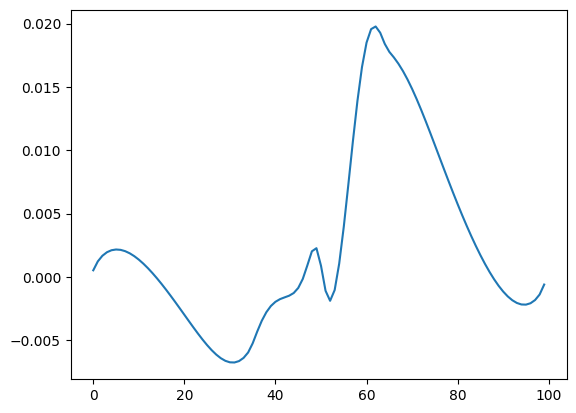

In [ ]:
plt.plot(CN_Cp)


0.022212872209692865

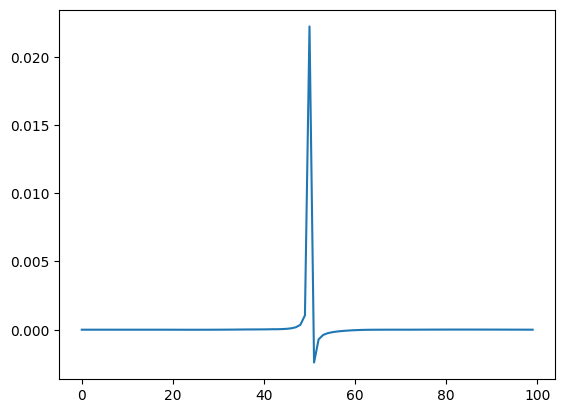

In [ ]:
plt.plot(CN_Cf)
np.max(CN_Cf)

0.006440498823864705

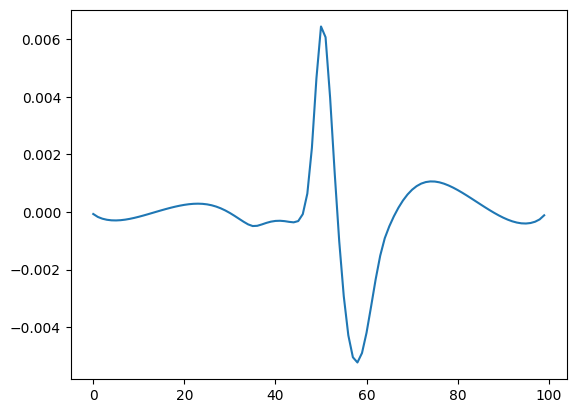

In [ ]:
plt.plot(CA_Cp)
np.max(CA_Cp)

0.0030371548286179653

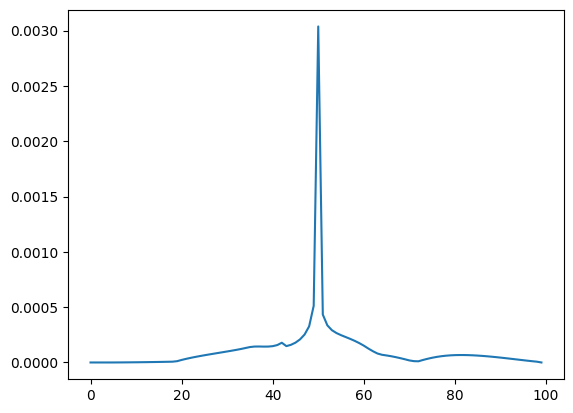

In [ ]:
plt.plot(CA_Cf)
np.max(CA_Cf)

**Checking Purpose**

In [ ]:
print("Maximum Cf : ",np.max(Cf))
print("Maximum delta_star : ", np.max(Delta_Star))
print("Maximum theta :", np.max(theta))
print("Delta at stagnation : ", Delta_Star[i_s])
print("Theta at stagnation : ", theta[i_s])
print("Lambda at stagnation : ", lam[i_s])
print("Cf at stagnation : ", Cf[i_s])

Maximum Cf :  3.436939648535639
Maximum delta_star :  0.029977521609817287
Maximum theta : 0.009439331935139234
Delta at stagnation :  0.0
Theta at stagnation :  0.0001616282628786562
Lambda at stagnation :  0.42306833455541193
Cf at stagnation :  0.34789502053106564


**Plot**

In [ ]:
YC_new = YC.copy()
for i in range(i_s):
  #if lam[i] > -0.09:
    YC_new[i] = YC_new[i] - Delta_Star[i]
        
  #if lam[-i-1] > -0.09:
    YC_new[-i-1] = YC_new[-i-1] + Delta_Star[-i-1]

Xnew = []
Ynew = []
for i in range(n):
    if YC_new[i] != YC[i]:
        Xnew.append(XC[i])
        Ynew.append(YC_new[i])

**Plotting the Airfoil and Boundary Layer**

In [ ]:
XC_u, XC_l = divide_Upper_Lower(XC, i_s)
theta_u, theta_l = divide_Upper_Lower(theta, i_s)
Delta_Star_u, Delta_Star_l = divide_Upper_Lower(Delta_Star, i_s)
lam_u, lam_l = divide_Upper_Lower(XC, i_s)
Cf_u, Cf_l = divide_Upper_Lower(Cf, i_s)
Cp_u, Cp_l = divide_Upper_Lower(Cp, i_s)

XC_l = np.append(XC_u[0], XC_l)
theta_l = np.append(theta_u[0], theta_l)
Delta_Star_l = np.append(Delta_Star_u[0], Delta_Star_l)
lam_l = np.append(lam_u[0], lam_l)
Cf_l = np.append(Cf_u[0], Cf_l)
Cp_l = np.append(Cp_u[0], Cp_l)

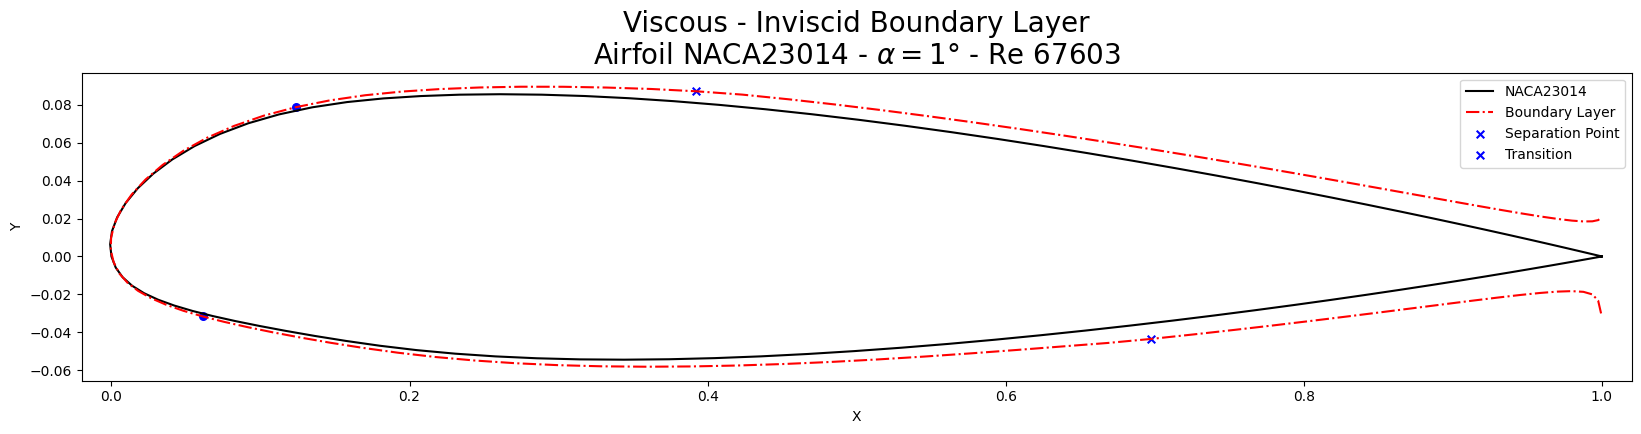

In [ ]:
fig = plt.figure(figsize=(20,4))
plt.plot(XB,YB, c='k')
plt.plot(XC,YC_new, c='r', ls='-.')
plt.scatter(XC[n_sep], YC_new[n_sep], s=30, marker = 'x', c='b')
plt.scatter(XC[n_sepl], YC_new[n_sepl], s=30, marker = 'x', c='b')


plt.scatter(XC[transp1], YC_new[transp1], s=30, marker = 'o', c='b')
plt.scatter(XC[transp2], YC_new[transp2], s=30, marker = 'o', c='b')

plt.legend([airfoil.upper() , 'Boundary Layer', 'Separation Point','Transition'])


plt.xlabel('X')
plt.ylabel('Y')
plt.xlim([-0.02,1.02])

title = 'Viscous - Inviscid Boundary Layer\n' + 'Airfoil ' + airfoil.upper() + ' - $\\alpha = $' + str(AoA) + '$\\degree$' + ' - Re ' + str(round(Re)) 
plt.title(title, size = 20)
plt.show()

# savename = 'Figure/' + Airfoil.upper() + '/AoA ' + str(AoA) + '_V ' +str(Vinf) + '/Boundary Layer'
# fig.savefig(savename , bbox_inches='tight')

In [ ]:
airfoil

'naca23014'

In [ ]:
X_JF  = []
DS_JF = []
T_JF  = []
Cf_JF = []
Cp_JF = []

if Vinf == 1:
    name = 'Javafoil/' + airfoil + '_BL' + str(AoA) + '.csv'
else:
    name = 'Javafoil/' + airfoil + '_BL' + str(AoA) + '_V' + str(Vinf) + '.csv'
file = open(name, "r")
for data in file:
    splittedData = data.rstrip().split(";")
    X_JF.append(float(splittedData[0]))
    DS_JF.append(float(splittedData[1]))
    T_JF.append(float(splittedData[2]))
    Cf_JF.append(float(splittedData[3]))

X_JF = np.array(X_JF[::-1], dtype=float)
DS_JF = np.array(DS_JF[::-1], dtype=float)
T_JF = np.array(T_JF[::-1], dtype=float)
Cf_JF = np.array(Cf_JF[::-1], dtype=float)
file.close()

name = 'Javafoil/' + airfoil + '_Cp' + str(AoA) + '.csv'
file = open(name, "r")
for data in file:
    splittedData = data.rstrip().split(";")
    Cp_JF.append(float(splittedData[1]))

Cp_JF = np.array(Cp_JF[::-1], dtype=float)
file.close()

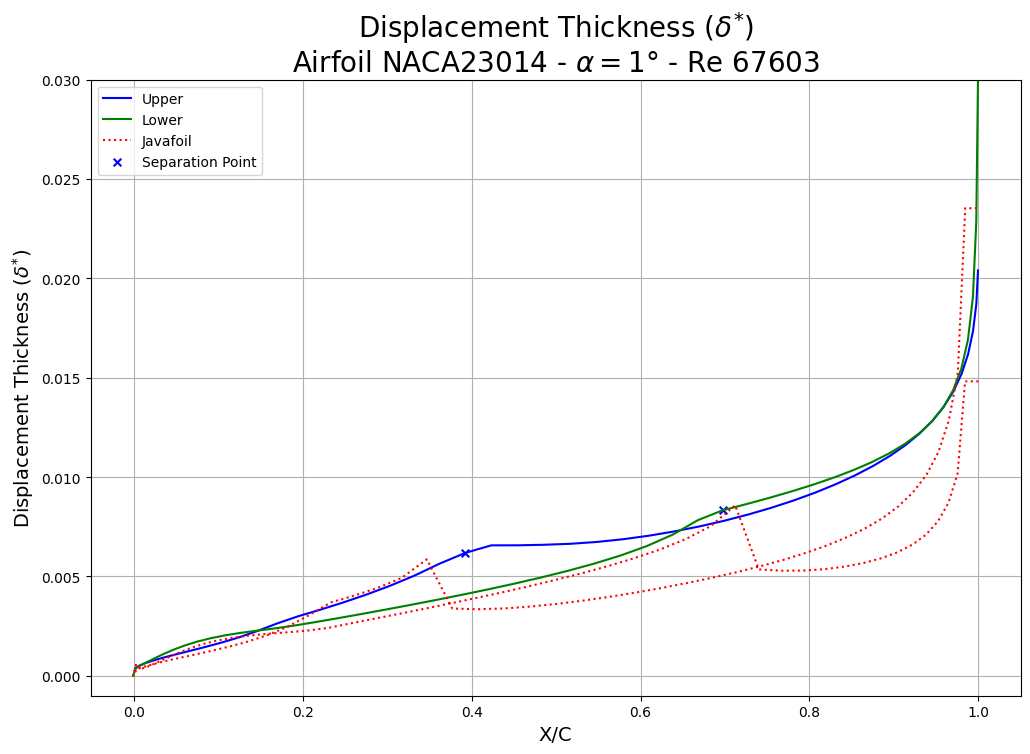

In [ ]:
fig=plt.figure(figsize=(12,8))
plt.plot(XC_u[1:],Delta_Star_u[1:], c='b')
plt.plot(XC_l[1:],Delta_Star_l[1:], c='g')
plt.plot(X_JF,DS_JF, linestyle = 'dotted', c='r')

plt.scatter(XC[n_sep], Delta_Star[n_sep], s=30, marker = 'x', c='b')
plt.scatter(XC[n_sepl], Delta_Star[n_sepl], s=30, marker = 'x', c='b')

plt.legend(['Upper', 'Lower', 'Javafoil', 'Separation Point'])

title = 'Displacement Thickness ($\delta^{*}$)\n' + 'Airfoil ' + airfoil.upper() + ' - $\\alpha = $' + str(AoA) + '$\\degree$' + ' - Re ' + str(round(Re))
plt.title(title, size='20')
plt.xlabel('X/C', size='14')
plt.ylabel('Displacement Thickness ($\delta^{*}$)', size='14')

plt.ylim([-0.001,0.03])

plt.grid('on')
plt.show()

# savename = 'Figure/' + Airfoil.upper() + '/AoA ' + str(AoA) + '_V ' +str(Vinf) + '/Displacement Thickness' 
# fig.savefig(savename,bbox_inches='tight')

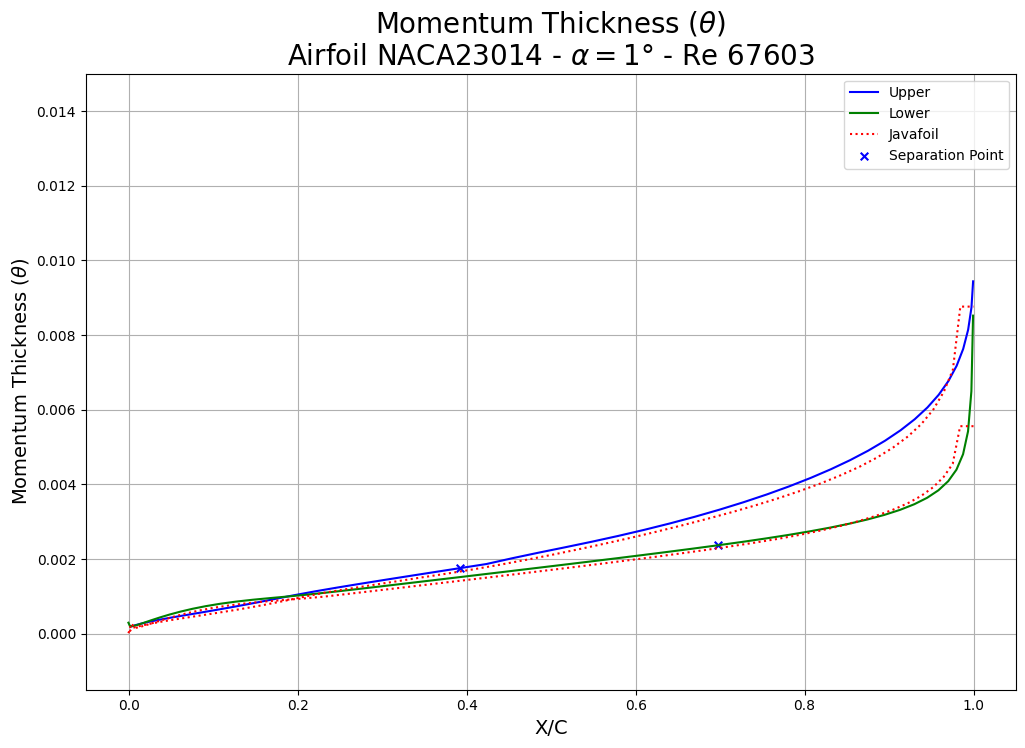

In [ ]:
fig=plt.figure(figsize=(12,8))
plt.plot(XC_u[1:],theta_u[1:], c='b')
plt.plot(XC_l[1:],theta_l[1:], c='g')
plt.plot(X_JF,T_JF, linestyle = 'dotted', c='r')

plt.scatter(XC[n_sep], theta[n_sep], s=30, marker = 'x', c='b')
plt.scatter(XC[n_sepl], theta[n_sepl], s=30, marker = 'x', c='b')

plt.legend(['Upper', 'Lower', 'Javafoil', 'Separation Point'])

title = 'Momentum Thickness ($\\theta$)\n' + 'Airfoil ' + airfoil.upper() + ' - $\\alpha = $' + str(AoA) + '$\\degree$' + ' - Re ' + str(round(Re))
plt.title(title, size='20')
plt.xlabel('X/C', size='14')
plt.ylabel('Momentum Thickness ($\\theta$)', size='14')

plt.ylim([-0.0015,0.015])

plt.grid('on')
plt.show()

# savename = 'Figure/' + Airfoil.upper() + '/AoA ' + str(AoA) + '_V ' +str(Vinf) + '/Momentum Thickness' 
# fig.savefig(savename,bbox_inches='tight')

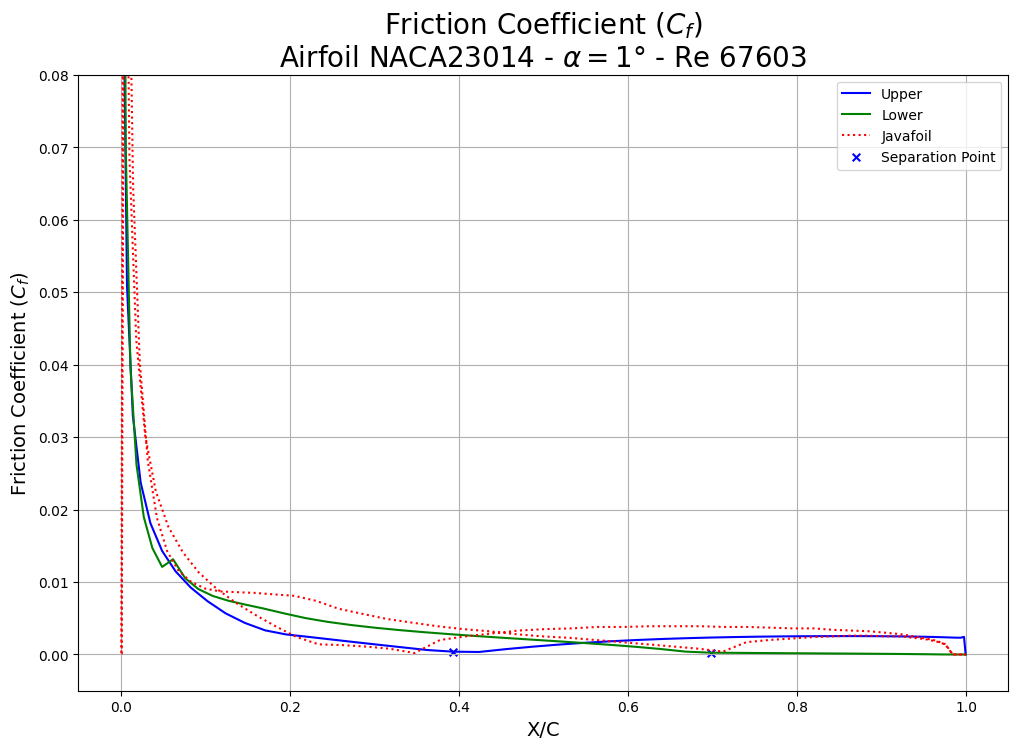

In [ ]:
fig=plt.figure(figsize=(12,8))
plt.plot(XC_u,Cf_u, c='b')
plt.plot(XC_l,Cf_l, c='g')
plt.plot(X_JF,Cf_JF, linestyle = 'dotted', c='r')

plt.scatter(XC[n_sep], Cf[n_sep], s=30, marker = 'x', c='b')
plt.scatter(XC[n_sepl], Cf[n_sepl], s=30, marker = 'x', c='b')

plt.legend(['Upper', 'Lower', 'Javafoil', 'Separation Point'])

title = 'Friction Coefficient ($C_f$)\n' + 'Airfoil ' + airfoil.upper() + ' - $\\alpha = $' + str(AoA) + '$\\degree$' + ' - Re ' + str(round(Re))
plt.title(title, size='20')
plt.xlabel('X/C', size='14')
plt.ylabel('Friction Coefficient ($C_f$)', size='14')

plt.ylim([-0.005,0.08])

plt.grid('on')
plt.show()

# savename = 'Figure/' + Airfoil.upper() + '/AoA ' + str(AoA) + '_V ' +str(Vinf) + '/CF' 
# fig.savefig(savename,bbox_inches='tight')

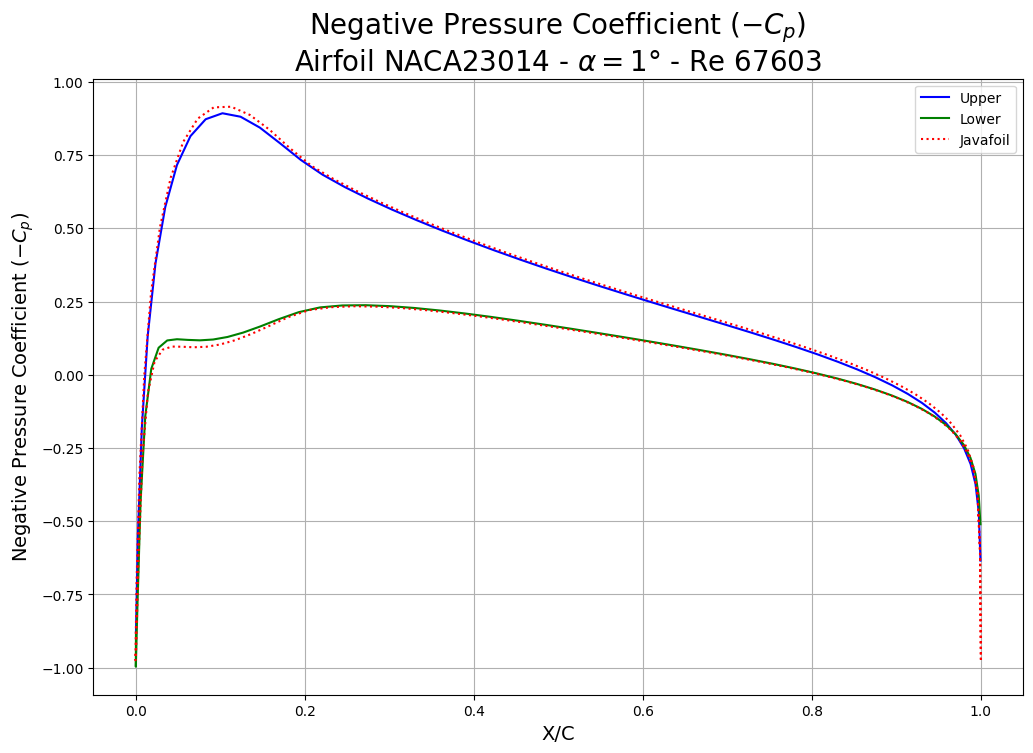

In [ ]:
fig=plt.figure(figsize=(12,8))
plt.plot(XC_u,-Cp_u, c='b')
plt.plot(XC_l,-Cp_l, c='g')
plt.plot(X_JF,-Cp_JF, linestyle = 'dotted', c='r')
plt.legend(['Upper', 'Lower', 'Javafoil'])


title = 'Negative Pressure Coefficient ($-C_p$)\n' + 'Airfoil ' + airfoil.upper() + ' - $\\alpha = $' + str(AoA) + '$\\degree$' + ' - Re ' + str(round(Re))
plt.title(title, size='20')
plt.xlabel('X/C', size='14')
plt.ylabel('Negative Pressure Coefficient ($-C_p$)', size='14')
plt.grid('on')
plt.show()

# savename = 'Figure/' + Airfoil.upper() + '/AoA ' + str(AoA) + '_V ' +str(Vinf) + '/CP' 
# fig.savefig(savename,bbox_inches='tight')

## Calculate Lift and Drag Coefficient Against Alpha